In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle
import re

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

# 統計モデル
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# 線形回帰
from sklearn import linear_model

# 誤差の評価
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# ワーニングを表示させない
import warnings
warnings.filterwarnings('ignore')

In [2]:
InputDir = "/home/onimem/work/Open_world/NBA/Graph/multiattribute"
OutputDir = "/home/onimem/work/Open_world/NBA/Model"

# 時系列グラフの読み込み
with open(InputDir + '/nba.graph', mode='rb') as f:
    graph = pickle.load(f)

# NULL attribute
dummy_year = 1950
dummy_name = 'Curly Armstrong'
NULL_ATTRIBUTE = {}
for k in graph[dummy_year]['nodes'][dummy_name].keys():
    NULL_ATTRIBUTE[k] = 'NULL'

# primary attribute key
PRIMARY_ATTRIBUTE_KEY = 'Tm'
# primary attribute values
PRIMARY_ATTRIBUTE_VALUES = ['ATL', 'BRK', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHO', 'PHI', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
# edge types
EDGE_TYPE_LIST = ['team']

# 過去Mステップから将来Hステップを予測する
M = 15
H = 1
YEARS = [i for i in range(1951+M, 2017-(M+H-1))]

In [3]:
def PlotHistory2(history, x, y1, y2, title, ylabel):
    plt.plot(history[x], history[y1], marker=".", color='#1ea8b5', label=y1)
    plt.plot(history[x], history[y2], marker=".", color='#ce405f', label=y2)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def IsUnique(seq):
    return len(seq) == len(set(seq))

def GetAllNodes(nodes_year1):
    if IsUnique(nodes_year1):
        return nodes_year1
    else :
        print("error")
        exit()

def GetNewNodes(nodes_year1, nodes_year2):
    if IsUnique(nodes_year1) and IsUnique(nodes_year2):
        new_nodes = set(nodes_year2) - set(nodes_year1)
        return new_nodes
    else :
        print("error")
        exit()

def GetLostNodes(nodes_year1, nodes_year2):
    if IsUnique(nodes_year1) and IsUnique(nodes_year2):
        lost_nodes = set(nodes_year1) - set(nodes_year2)
        return lost_nodes
    else :
        print("error")
        exit()

def GetStayNodes(nodes_year1, nodes_year2):
    if IsUnique(nodes_year1) and IsUnique(nodes_year2):
        stay_nodes = set(nodes_year1) and set(nodes_year2)
        return stay_nodes
    else :
        print("error")
        exit()

def GetUnknownNodes(graph, year, M):
    new_nodes = GetNewNodes(graph[year-1]['nodes'], graph[year]['nodes'])
    U = GetObservedNodeSet(graph, year-1, M)
    return new_nodes - U

def GetReturnNodes(graph, year, M):
    new_nodes = GetNewNodes(graph[year-1]['nodes'], graph[year]['nodes'])
    return new_nodes - GetUnknownNodes(graph, year, M)

def GetObservedNodeSet(graph, year, M):
    U = set()
    for i in range(M):
        U |= set(graph[year-i]['nodes'])
    return U

def LinearRegression(years_all, years_train, node_num_train):
    # Learn
    X = pd.DataFrame(years_train)
    Y = pd.DataFrame(node_num_train)
    model = linear_model.LinearRegression()
    model.fit(X, Y)
    # predict
    px = np.array(years_all)[:,np.newaxis] # convert to 2D numpy array due to sklearn specification
    py = model.predict(px)
    py = py.reshape(-1).tolist()
    return py

def RebuildPrimaryAttributeGraph(graph, years):
    primary_attribute_graph = {}
    for primary_attribute_value in PRIMARY_ATTRIBUTE_VALUES:
        primary_attribute_graph[primary_attribute_value] = {}
        for year in years:
            primary_attribute_graph[primary_attribute_value][year] = {}
            primary_attribute_graph[primary_attribute_value][year]['nodes'] = {}
            primary_attribute_graph[primary_attribute_value][year]['edges'] = {}
            for name, attribute in graph[year]['nodes'].items():
                if attribute[PRIMARY_ATTRIBUTE_KEY] == primary_attribute_value:
                    primary_attribute_graph[primary_attribute_value][year]['nodes'][name] = graph[year]['nodes'][name]
            name_list = list(primary_attribute_graph[primary_attribute_value][year]['nodes'].keys())
            for edge_type in EDGE_TYPE_LIST:
                primary_attribute_graph[primary_attribute_value][year]['edges'][edge_type] = []
                for edge in graph[year]['edges'][edge_type]:
                    if (edge[0] in name_list) and (edge[1] in name_list):
                        primary_attribute_graph[primary_attribute_value][year]['edges'][edge_type].append(edge)
    return primary_attribute_graph

def GetNodes(year, graph, mode='all', M=0):
    if mode == 'unknown':
        nodes = GetUnknownNodes(graph, year, M)
    elif mode == 'return':
        nodes = GetReturnNodes(graph, year, M)
    elif mode == 'lost':
        nodes = GetLostNodes(graph[year-1]['nodes'], graph[year]['nodes'])
    elif mode == 'all':
        nodes = GetAllNodes(graph[year]['nodes'])
    elif mode == 'stay':
        nodes = GetStayNodes(graph[year-1]['nodes'], graph[year]['nodes'])
    return nodes

def GetNodeNum(year, graph, mode='all', M=0):
    return float(len(GetNodes(year, graph, mode, M)))

def GetNodeNumList(years, graph, mode='all', M=0):
    node_num = []
    for year in years:
        node_num.append(GetNodeNum(year, graph, mode, M))
    return node_num

def GetPredictedNodeNumAll(years_all, years_train, graph, plot_title='title', mode='all', M=0):
    # get num of nodes
    node_num_all = GetNodeNumList(years_all, graph, mode, M)
    node_num_train = GetNodeNumList(years_train, graph, mode, M)
    # learning & predict (LinearRegression)
    predicted_node_num_all = LinearRegression(years_all, years_train, node_num_train)
    # plot result
    history = {'year':years_all, 'true':node_num_all, 'pred':predicted_node_num_all}
    PlotHistory2(history, 'year', 'true', 'pred', title=plot_title, ylabel="# of node")
    return predicted_node_num_all

def GetPredictedNodeNumTest(years_all, years_train, graph, plot_title='title', mode='all', M=0):
    predicted_node_num_all = GetPredictedNodeNumAll(years_all, years_train, graph, plot_title, mode, M)
    predicted_node_num_test = list(map(lambda x: round(x), predicted_node_num_all[len(years_train):]))
    return predicted_node_num_test

def GetPredictedNodeNumTestGroupbyPrimaryAttributeValue(years_all, years_train, primary_attribute_graph, mode='all', M=0):
    predicted_node_num_test_groupby_primary_attribute_value = {}
    for primary_attribute_value, graph in primary_attribute_graph.items():
        predicted_node_num_test_groupby_primary_attribute_value[primary_attribute_value] = GetPredictedNodeNumTest(years_all, years_train, graph, primary_attribute_value, mode, M)
    return predicted_node_num_test_groupby_primary_attribute_value

def GenerateYearsList(year, M, H):
    # train_year:Mステップ, test_year:Hステップ, years_all:M+Hステップ
    years_train = [(year+m) for m in range(M)]
    years_test = [(years_train[-1]+h+1) for h in range(H)]
    years_all = years_train.copy()
    years_all.extend(years_test)
    return years_train, years_test, years_all

########################################################################################################################################

def GetInputGraph(graph, years_train, years_test, M, predicted_node_num_unknown_groupby_primary_attribute_value):
    # generate node set of input graph
    V = GenerateNodeSetOfInputGraph(graph, years_train, years_test, M, predicted_node_num_unknown_groupby_primary_attribute_value)
    # generate edge set of input graph
    E = GenerateEdgeSetOfInputGraph(graph, years_train, years_test, M, predicted_node_num_unknown_groupby_primary_attribute_value, V)
    # generate input graph
    input_graph = GenerateInputGraph(V, E, graph, years_train)
    return input_graph

########################################################################################################################################

def GenerateNodeSetOfInputGraph(graph, years_train, years_test, M, predicted_node_num_unknown_groupby_primary_attribute_value):
    # initialize node set
    V = set()
    # add observed node set of train year
    V |= GetObservedNodeSet(graph, years_train[-1], M)
    # add unknown nodes of test year
    V |= GetUnknownNodeSet(predicted_node_num_unknown_groupby_primary_attribute_value, years_test)
    return V

def GetUnknownNodeSet(predicted_node_num_unknown_groupby_primary_attribute_value, years_test):
    # initialize node set
    unknown_node_set = set()
    for i in range(len(years_test)):
        year = years_test[i]
        for primary_attribute_value, predicted_node_num_unknown in predicted_node_num_unknown_groupby_primary_attribute_value.items():
            for j in range(predicted_node_num_unknown[i]):
                unknown_node_set.add('unknown_' + primary_attribute_value + '_' + str(year) + '_' + str(j))
    return unknown_node_set

########################################################################################################################################

def GenerateEdgeSetOfInputGraph(graph, years_train, years_test, M, predicted_node_num_unknown_groupby_primary_attribute_value, V):
    # initialize edge set
    E = set()
    # add observed edge set of train year
    E |= GetObservedEdgeSet(graph, years_train[-1], M)
    # add unknown edges of test year
    E |= GetUnknownEdgeSet(years_train, graph, V)
    return E

def GetObservedEdgeSet(graph, year, M):
    D = set()
    for i in range(M):
        for edge_type in EDGE_TYPE_LIST:
            D |= {(edge[0], edge[1], edge_type, year-i) for edge in graph[year-i]['edges'][edge_type]}
    return D

def GetUnknownEdgeSet(years_train, graph, V):
    unknown_edge_set = set()
    for unknown_node in V:
        if not IsUnknownNode(unknown_node):
            continue
        primary_attribute_value = GetPrimaryAttributeValueFromUnknownNode(unknown_node)
        year = GetYearOfUnknownNode(unknown_node)
        for edge_type in EDGE_TYPE_LIST:
            for similar_node in GetSimilarNodeSet(primary_attribute_value, unknown_node, V, years_train, graph):
                unknown_edge_set |= ({(unknown_node, similar_node, edge_type, year), (similar_node, unknown_node, edge_type, year)})
    return unknown_edge_set

def IsUnknownNode(node):
    return node.split('_')[0] == 'unknown'

def GetPrimaryAttributeValueFromUnknownNode(unknown_node):
    return unknown_node.split('_')[1]

def GetYearOfUnknownNode(unknown_node):
    return int(unknown_node.split('_')[2])

########################################################################################################################################

def GetSimilarNodeSet(src_primary_attribute_value, src_node, V, years_train, graph):
    similar_node_set = set()
    for dist_node in V:
        if dist_node == src_node:
            continue
        if IsUnknownNode(dist_node):
            dist_primary_attribute_value = GetPrimaryAttributeValueFromUnknownNode(dist_node)
        else:
            dist_primary_attribute_value = GetPrimaryAttributeValueFromObservedNode(dist_node, years_train, graph)
        if src_primary_attribute_value == dist_primary_attribute_value:
            similar_node_set.add(dist_node)
    return similar_node_set

# return the latest attribute of node
def GetPrimaryAttributeValueFromObservedNode(node, years, graph):
    for year in years:
        for name, attribute in graph[year]['nodes'].items():
            if name == node:
                primary_attribute_value = attribute[PRIMARY_ATTRIBUTE_KEY]
    return primary_attribute_value

########################################################################################################################################

def GenerateInputGraph(V, E, graph, years_train):
    input_graph = {}
    for year in years_train:
        input_graph[year] = {}
        input_graph[year]['nodes'] = {}
        input_graph[year]['edges'] = {}
        for edge_type in EDGE_TYPE_LIST:
            edge_set_of_edge_type = {edge if edge[2] == edge_type else None for edge in E}
            edge_set_of_edge_type.add(None) # add at least one None
            edge_set_of_edge_type.remove(None)
            input_graph[year]['edges'][edge_type] = edge_set_of_edge_type
        for node in V:
            input_graph[year]['nodes'][node] = {}
            if node in graph[year]['nodes'].keys():
                input_graph[year]['nodes'][node] = graph[year]['nodes'][node]
            else:
                input_graph[year]['nodes'][node] = NULL_ATTRIBUTE
    return input_graph

# for confirm node attribute
def PrintNodeAttribute(years_train, input_graph):
    tmp_year = list(input_graph.keys())[0] # anything is fine
    for name in input_graph[tmp_year]['nodes'].keys():
        for year in years_train:
            print(name, year, input_graph[year]['nodes'][name])

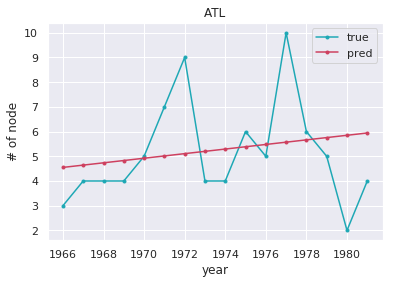

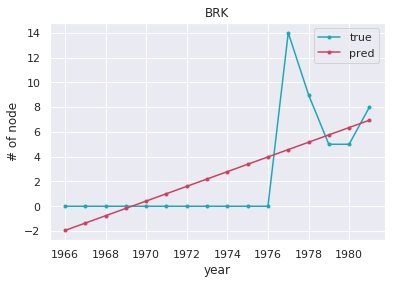

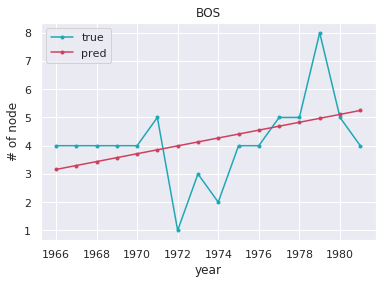

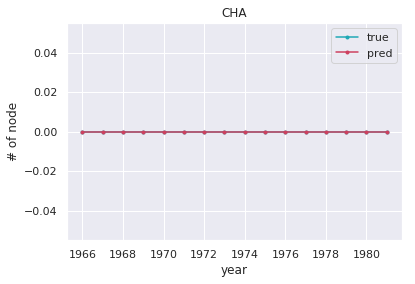

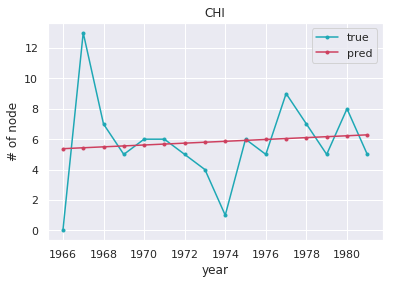

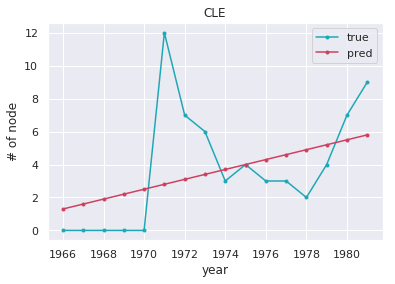

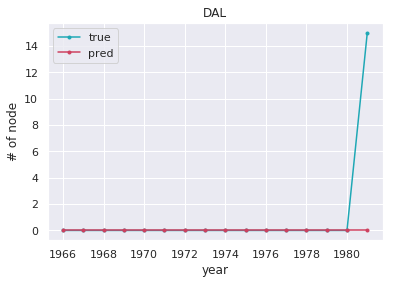

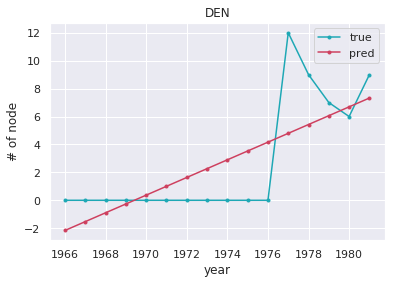

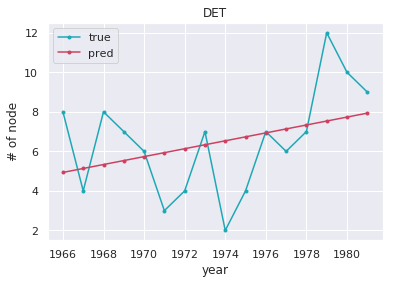

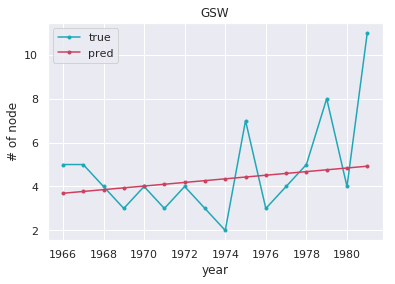

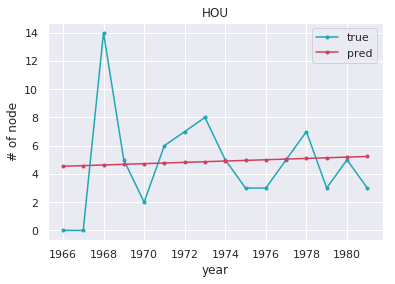

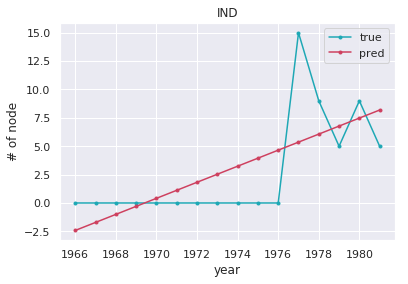

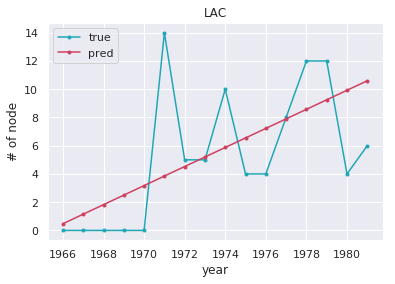

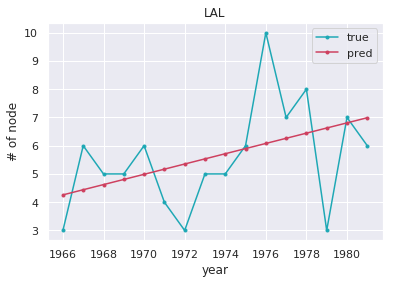

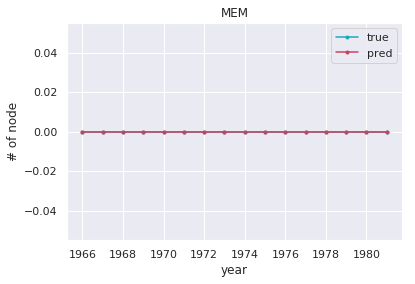

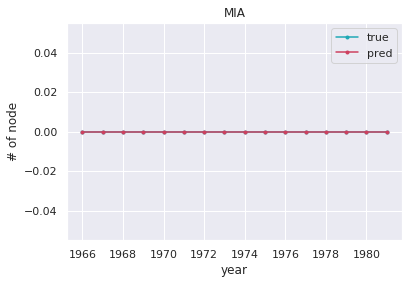

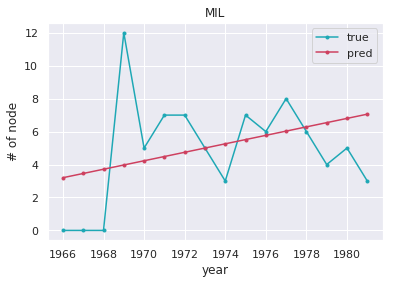

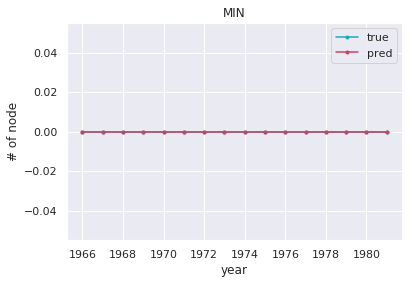

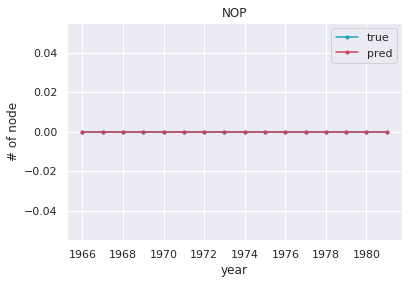

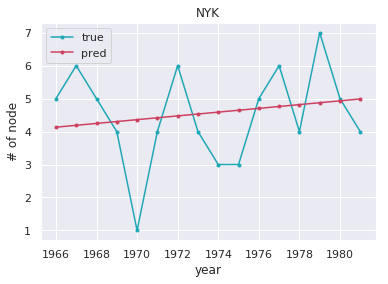

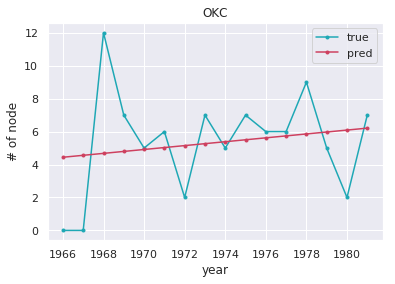

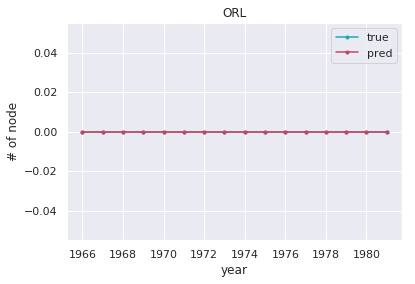

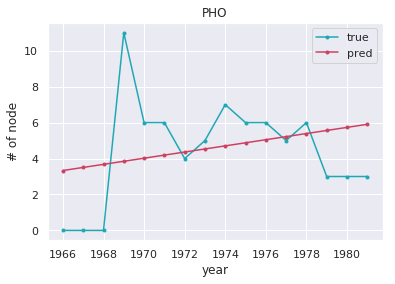

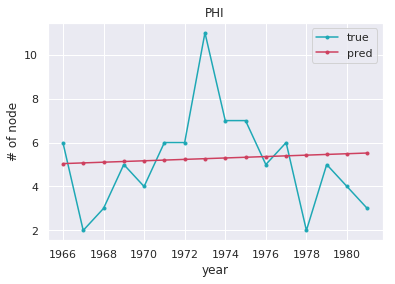

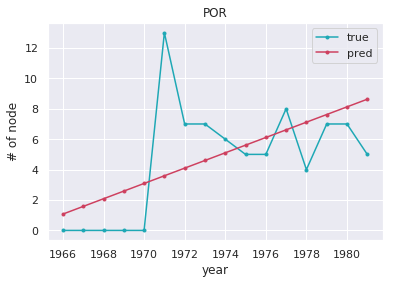

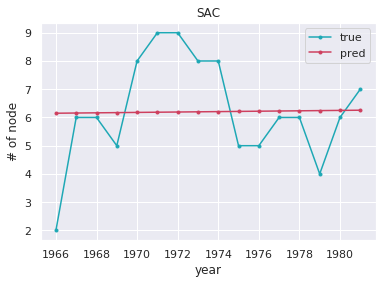

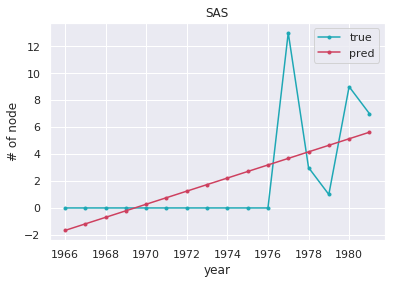

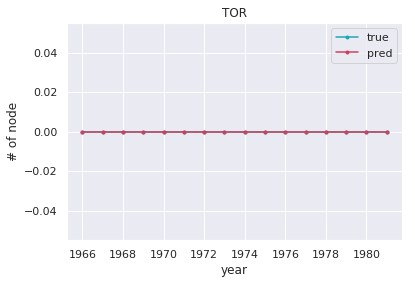

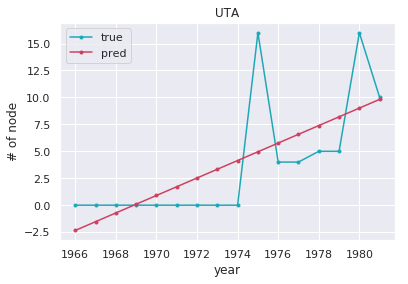

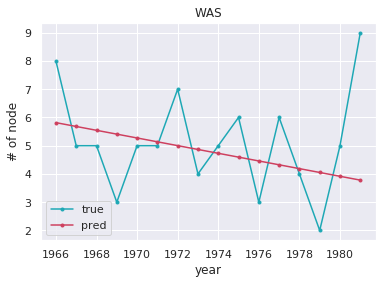

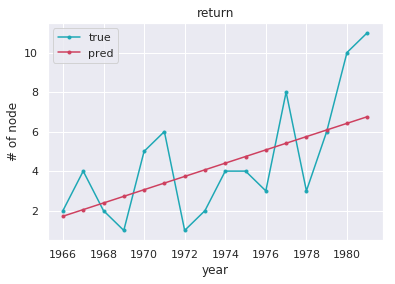

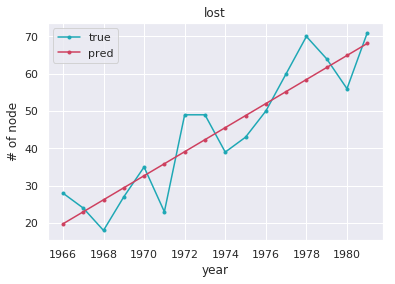

NameError: name 'STGCN' is not defined

In [4]:
# Rebuild graph to primary attribute graph
primary_attribute_graph = RebuildPrimaryAttributeGraph(graph, [i for i in range(1950, 2018)])

for year in YEARS:
    # get time step list
    years_train, years_test, years_all = GenerateYearsList(year, M, H)
    # get # of unknown node, return node, lost node.
    predicted_node_num_unknown_groupby_primary_attribute_value = GetPredictedNodeNumTestGroupbyPrimaryAttributeValue(years_all, years_train, primary_attribute_graph, 'unknown', M)
    predicted_node_num_return = GetPredictedNodeNumTest(years_all, years_train, graph, 'return', 'return', M)
    predicted_node_num_lost = GetPredictedNodeNumTest(years_all, years_train, graph, 'lost', 'lost', M)
    # get input graph
    input_graph = GetInputGraph(graph, years_train, years_test, M, predicted_node_num_unknown_groupby_primary_attribute_value)
    #PrintNodeAttribute(years_train, input_graph)
    
    STGCN(input_graph, )    

In [ ]:
years_train, years_test, years_all = GenerateYearsList(1951, 66, 1)
GetPredictedNodeNumTest(years_all, years_train, graph, plot_title='NBA Players', mode='all', M=0)